## Libraries

In [1]:
# Essentials
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm, ListedColormap
from matplotlib.patches import Ellipse
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from skbio.stats.ordination import pcoa
from skbio.stats.distance import DistanceMatrix, permanova
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score
import scipy.stats as stats
from scipy.stats import spearmanr
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mannwhitneyu, kruskal, nbinom, multivariate_normal
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import pandas as pd
import os
import re
import random
import statsmodels.api as sm
import seaborn as sns
import networkx as nx
# User libraries
from BatchEffectDataLoader import DataPreprocess, DataTransform, one_hot_encoding
from BatchEffectCorrection import correctCombat, correctLimma_rBE, correctBMC, correctPLSDAbatch_R, correctCombatSeq, correctConQuR
from BatchEffectPlots import plotPCA, plotPCoA, plot_LISI_perplexity
from BatchEffectMetrics import all_metrics, pairwise_distance, pairwise_distance_std, PERMANOVA, pairwise_distance_multi_run, kBET, ARI, ASW, iLISI_norm
from ABaCo import abaco_run, abaco_recon, contour_plot, abaco_run_ensemble, abaco_recon_ensemble

>> clustergrammer2 backend version 0.18.0


## Data loading

### Original datasets

In [2]:
# Load AD count
path = "data/dataset_ad.csv"
ad_count_batch_label = "batch"
ad_count_sample_label = "sample"
ad_count_bio_label = "trt"

ad_count_data = DataPreprocess(
    path,
    factors=[ad_count_sample_label, ad_count_batch_label, ad_count_bio_label]
)

# train DataLoader: [samples, ohe_batch]
ad_count_input_size = 567
ad_count_train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(ad_count_data.select_dtypes(include="number").values, dtype=torch.float32), # samples
        one_hot_encoding(ad_count_data[ad_count_batch_label])[0], # one hot encoded batch information
        one_hot_encoding(ad_count_data[ad_count_bio_label])[0], #one hot encoded biological information
    ),
    batch_size=1000,
)
ad_count_batch_size = 5
ad_count_bio_size = 2

# Load IBD data
path = "data/MGnify/IBD/IBD_dataset_genus.csv"
ibd_batch_label = "project ID"
ibd_sample_label = "run ID"
ibd_bio_label = "associated phenotype"

ibd_data = DataPreprocess(
    path,
    factors=[ibd_sample_label, ibd_batch_label, ibd_bio_label]
)

# train DataLoader: [samples, ohe_batch]
ibd_input_size = 193
ibd_train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(ibd_data.select_dtypes(include="number").values, dtype=torch.float32), # samples
        one_hot_encoding(ibd_data[ibd_batch_label])[0], # one hot encoded batch information
        one_hot_encoding(ibd_data[ibd_bio_label])[0], #one hot encoded biological information
    ),
    batch_size=1000,
)
ibd_batch_size = 2
ibd_bio_size = 3

# Load DTU-GE data
path = "data/MGnify/DTU-GE/count/DTU-GE_phylum_count_data_filtered.csv"
dtu_batch_label = "pipeline"
dtu_sample_label = "accession"
dtu_bio_label = "location"

dtu_data = DataPreprocess(
    path,
    factors=[dtu_sample_label, dtu_batch_label, dtu_bio_label]
)

# train DataLoader: [samples, ohe_batch]
dtu_input_size = 162
dtu_train_dataloader = DataLoader(
    TensorDataset(
        torch.tensor(dtu_data.select_dtypes(include="number").values, dtype=torch.float32), # samples
        one_hot_encoding(dtu_data[dtu_batch_label])[0], # one hot encoded batch information
        one_hot_encoding(dtu_data[dtu_bio_label])[0], #one hot encoded biological information
    ),
    batch_size=1000,
)
dtu_batch_size = 2
dtu_bio_size = 4

ad_count_data_clr = DataTransform(data = ad_count_data, factors=[ad_count_sample_label, ad_count_batch_label, ad_count_bio_label], transformation="CLR", count=True)
ibd_data_clr = DataTransform(data = ibd_data, factors=[ibd_sample_label, ibd_batch_label, ibd_bio_label], transformation="CLR", count=True)
dtu_data_clr = DataTransform(data = dtu_data, factors=[dtu_sample_label, dtu_batch_label, dtu_bio_label], transformation="CLR", count=True)

### ABaCo runs

In [4]:
datasets = ["AD_count", "IBD", "DTU-GE"]
dataset_labels = ["AD count", "IBD", "DTU-GE"]
priors = ["vmm_kl", "mog_kl", "std_kl", "vmm_no", "mog_no", "std_no"]
prior_labels = ["VMM w/ KL cycle", "MoG w/ KL cycle", "Std w/ KL cycle", "VMM w/o KL cycle", "MoG w/o KL cycle", "Std w/o KL cycle"]
mult = 1
bio_label = ["trt", "associated phenotype", "location"]
sample_label = ["sample", "run ID", "accession"]
batch_label = ["batch", "project ID", "pipeline"]

multi_runs = []

for j, dataset in enumerate(datasets):
    folder = f"performance_metrics/multi_runs/{dataset}"

    for k, prior in enumerate(priors):
        if (dataset == "DTU-GE"):
            if (prior == "vmm_kl") | (prior == "vmm_no"):
                file_paths = [os.path.join(folder, file) 
                                for file in os.listdir(folder) 
                                if file.startswith(prior) and 
                                os.path.isfile(os.path.join(folder, file)) and
                                int(re.search(r"\d+$", file).group()) % mult == 0 and
                                re.search(r"kl_annealing_\d+$", os.path.splitext(file)[0])]
                
            else:
                file_paths = [os.path.join(folder, file) 
                                for file in os.listdir(folder) 
                                if file.startswith(prior) and 
                                os.path.isfile(os.path.join(folder, file)) and
                                int(re.search(r"\d+$", file).group()) % mult == 0 and
                                re.search(r"contra_1000_\d+$", os.path.splitext(file)[0])]
            
        elif (dataset == "IBD"):
            if (prior == "vmm_kl") | (prior == "vmm_no"):
                file_paths = [os.path.join(folder, file) 
                                for file in os.listdir(folder) 
                                if file.startswith(prior) and 
                                os.path.isfile(os.path.join(folder, file)) and
                                int(re.search(r"\d+$", file).group()) % mult == 0 and
                                re.search(r"kl_annealing_\d+$", os.path.splitext(file)[0])]
                
            else:
                file_paths = [os.path.join(folder, file) 
                                for file in os.listdir(folder) 
                                if file.startswith(prior) and 
                                os.path.isfile(os.path.join(folder, file)) and
                                int(re.search(r"\d+$", file).group()) % mult == 0 and
                                re.search(r"contra_1000_2_\d+$", os.path.splitext(file)[0])]

        else:
            file_paths = [os.path.join(folder, file) 
                            for file in os.listdir(folder) 
                            if file.startswith(prior) and 
                            os.path.isfile(os.path.join(folder, file)) and
                            int(re.search(r"\d+$", file).group()) % mult == 0]

        for i, file in enumerate(file_paths):
            run = DataPreprocess(path = file, factors = [sample_label[j], batch_label[j], bio_label[j]])
            run_format = {
                "iter":i,
                "dataset": dataset,
                "run": run,
                "prior": prior,
                "path":file,
            }
            multi_runs.append(run_format)

multi_runs = pd.DataFrame(multi_runs)

## 1. Robustness in differentially regulated taxa

### Define Kruskal-wallis test

In [5]:
# Define function to compute Kruskal-Wallis per taxa
def kruskal_wallis_taxa(df, sample_label, batch_label, bio_label, method):
    # Melt dataframe
    melt_df = pd.melt(df, id_vars = [sample_label, batch_label, bio_label], var_name = "taxa", value_name = "norm_counts")
    # Comput K-W test
    results = []
    # Per taxa
    for taxon, df_taxa in melt_df.groupby("taxa"):
        # For each biological group
        groups = []

        for grp, df_grp in df_taxa.groupby(bio_label):

            groups.append(df_grp["norm_counts"].values)

        try:
            stat, pval = kruskal(*groups)
            
        except ValueError:
            continue

        results.append({"taxa":taxon,
                        "H_stat":stat,
                        "p-value":pval})

    kw_df = pd.DataFrame(results)

    rej, p_adj, _, _ = multipletests(kw_df["p-value"], method = "fdr_bh")
    kw_df["p_adj"] = p_adj
    kw_df["significant"] = rej
    kw_df["method"] = method
    return kw_df

### Kruskal-wallis on all runs

In [6]:
priors = ["vmm_no", "vmm_kl", "std_no", "std_kl"]
prior_labels = ["ABaCo", "ABaCo (w/ KL cycle)"]
dataset_labels = ["Anaerobic digestion dataset", "IBD dataset", "DTU-GE dataset"]

# Original
ad_taxa_cols = ad_count_data_clr.select_dtypes(include = "number").columns
ad_non_num_cols = ad_count_data_clr.select_dtypes(exclude = "number").columns

ibd_taxa_cols = ibd_data_clr.select_dtypes(include = "number").columns
ibd_non_num_cols = ibd_data_clr.select_dtypes(exclude = "number").columns

dtu_taxa_cols = dtu_data_clr.select_dtypes(include = "number").columns
dtu_non_num_cols = dtu_data_clr.select_dtypes(exclude = "number").columns

non_num_cols = [ad_non_num_cols, ibd_non_num_cols, dtu_non_num_cols]
taxa_cols = [ad_taxa_cols, ibd_taxa_cols, dtu_taxa_cols]

robust_results = pd.DataFrame()

for i, dataset in enumerate(datasets):

    for j, prior in enumerate(priors):

        if (dataset == "AD_count") & ((prior == "vmm_no") | (prior == "vmm_kl")):

            print(dataset)
            print(prior)

            abaco_runs = multi_runs[(multi_runs["dataset"] == dataset) & (multi_runs["prior"] == prior)]
            
            kw_results_abaco = pd.DataFrame()

            for k, abaco_run in enumerate(abaco_runs["run"]):

                recon_data = DataTransform(abaco_run, factors = [sample_label[i], batch_label[i], bio_label[i]], count = True)

                top_taxa_abaco_data = recon_data[list(non_num_cols[i]) + list(taxa_cols[i])]
                kw_results_abaco = pd.concat([kw_results_abaco, kruskal_wallis_taxa(top_taxa_abaco_data, sample_label[i], batch_label[i], bio_label[i], k)], axis = 0)
            
            kw_results_abaco["dataset"] = dataset
            kw_results_abaco["prior"] = prior

            robust_results = pd.concat([robust_results, kw_results_abaco], axis = 0)
        
        elif ((dataset == "IBD") | (dataset == "DTU-GE")) & ((prior == "std_no") | (prior == "std_kl")):

            print(dataset)
            print(prior)

            abaco_runs = multi_runs[(multi_runs["dataset"] == dataset) & (multi_runs["prior"] == prior)]
            
            kw_results_abaco = pd.DataFrame()

            for k, abaco_run in enumerate(abaco_runs["run"]):

                recon_data = DataTransform(abaco_run, factors = [sample_label[i], batch_label[i], bio_label[i]], count = True)

                top_taxa_abaco_data = recon_data[list(non_num_cols[i]) + list(taxa_cols[i])]
                kw_results_abaco = pd.concat([kw_results_abaco, kruskal_wallis_taxa(top_taxa_abaco_data, sample_label[i], batch_label[i], bio_label[i], k)], axis = 0)
            
            kw_results_abaco["dataset"] = dataset
            kw_results_abaco["prior"] = prior

            robust_results = pd.concat([robust_results, kw_results_abaco], axis = 0)

AD_count
vmm_no
AD_count
vmm_kl
IBD
std_no
IBD
std_kl
DTU-GE
std_no
DTU-GE
std_kl


### Filtering only taxonomic groups that appeared at least once as significant

In [7]:
new_df = pd.DataFrame()

for j, taxa in enumerate(robust_results["taxa"].unique()):
    for i, prior in enumerate(robust_results["prior"].unique()):
        selected = robust_results[(robust_results["taxa"] == taxa) & (robust_results["prior"] == prior)]
        if selected["significant"].sum() > 0:
            new_df = pd.concat([new_df, selected], axis = 0)

### Plotting heat map

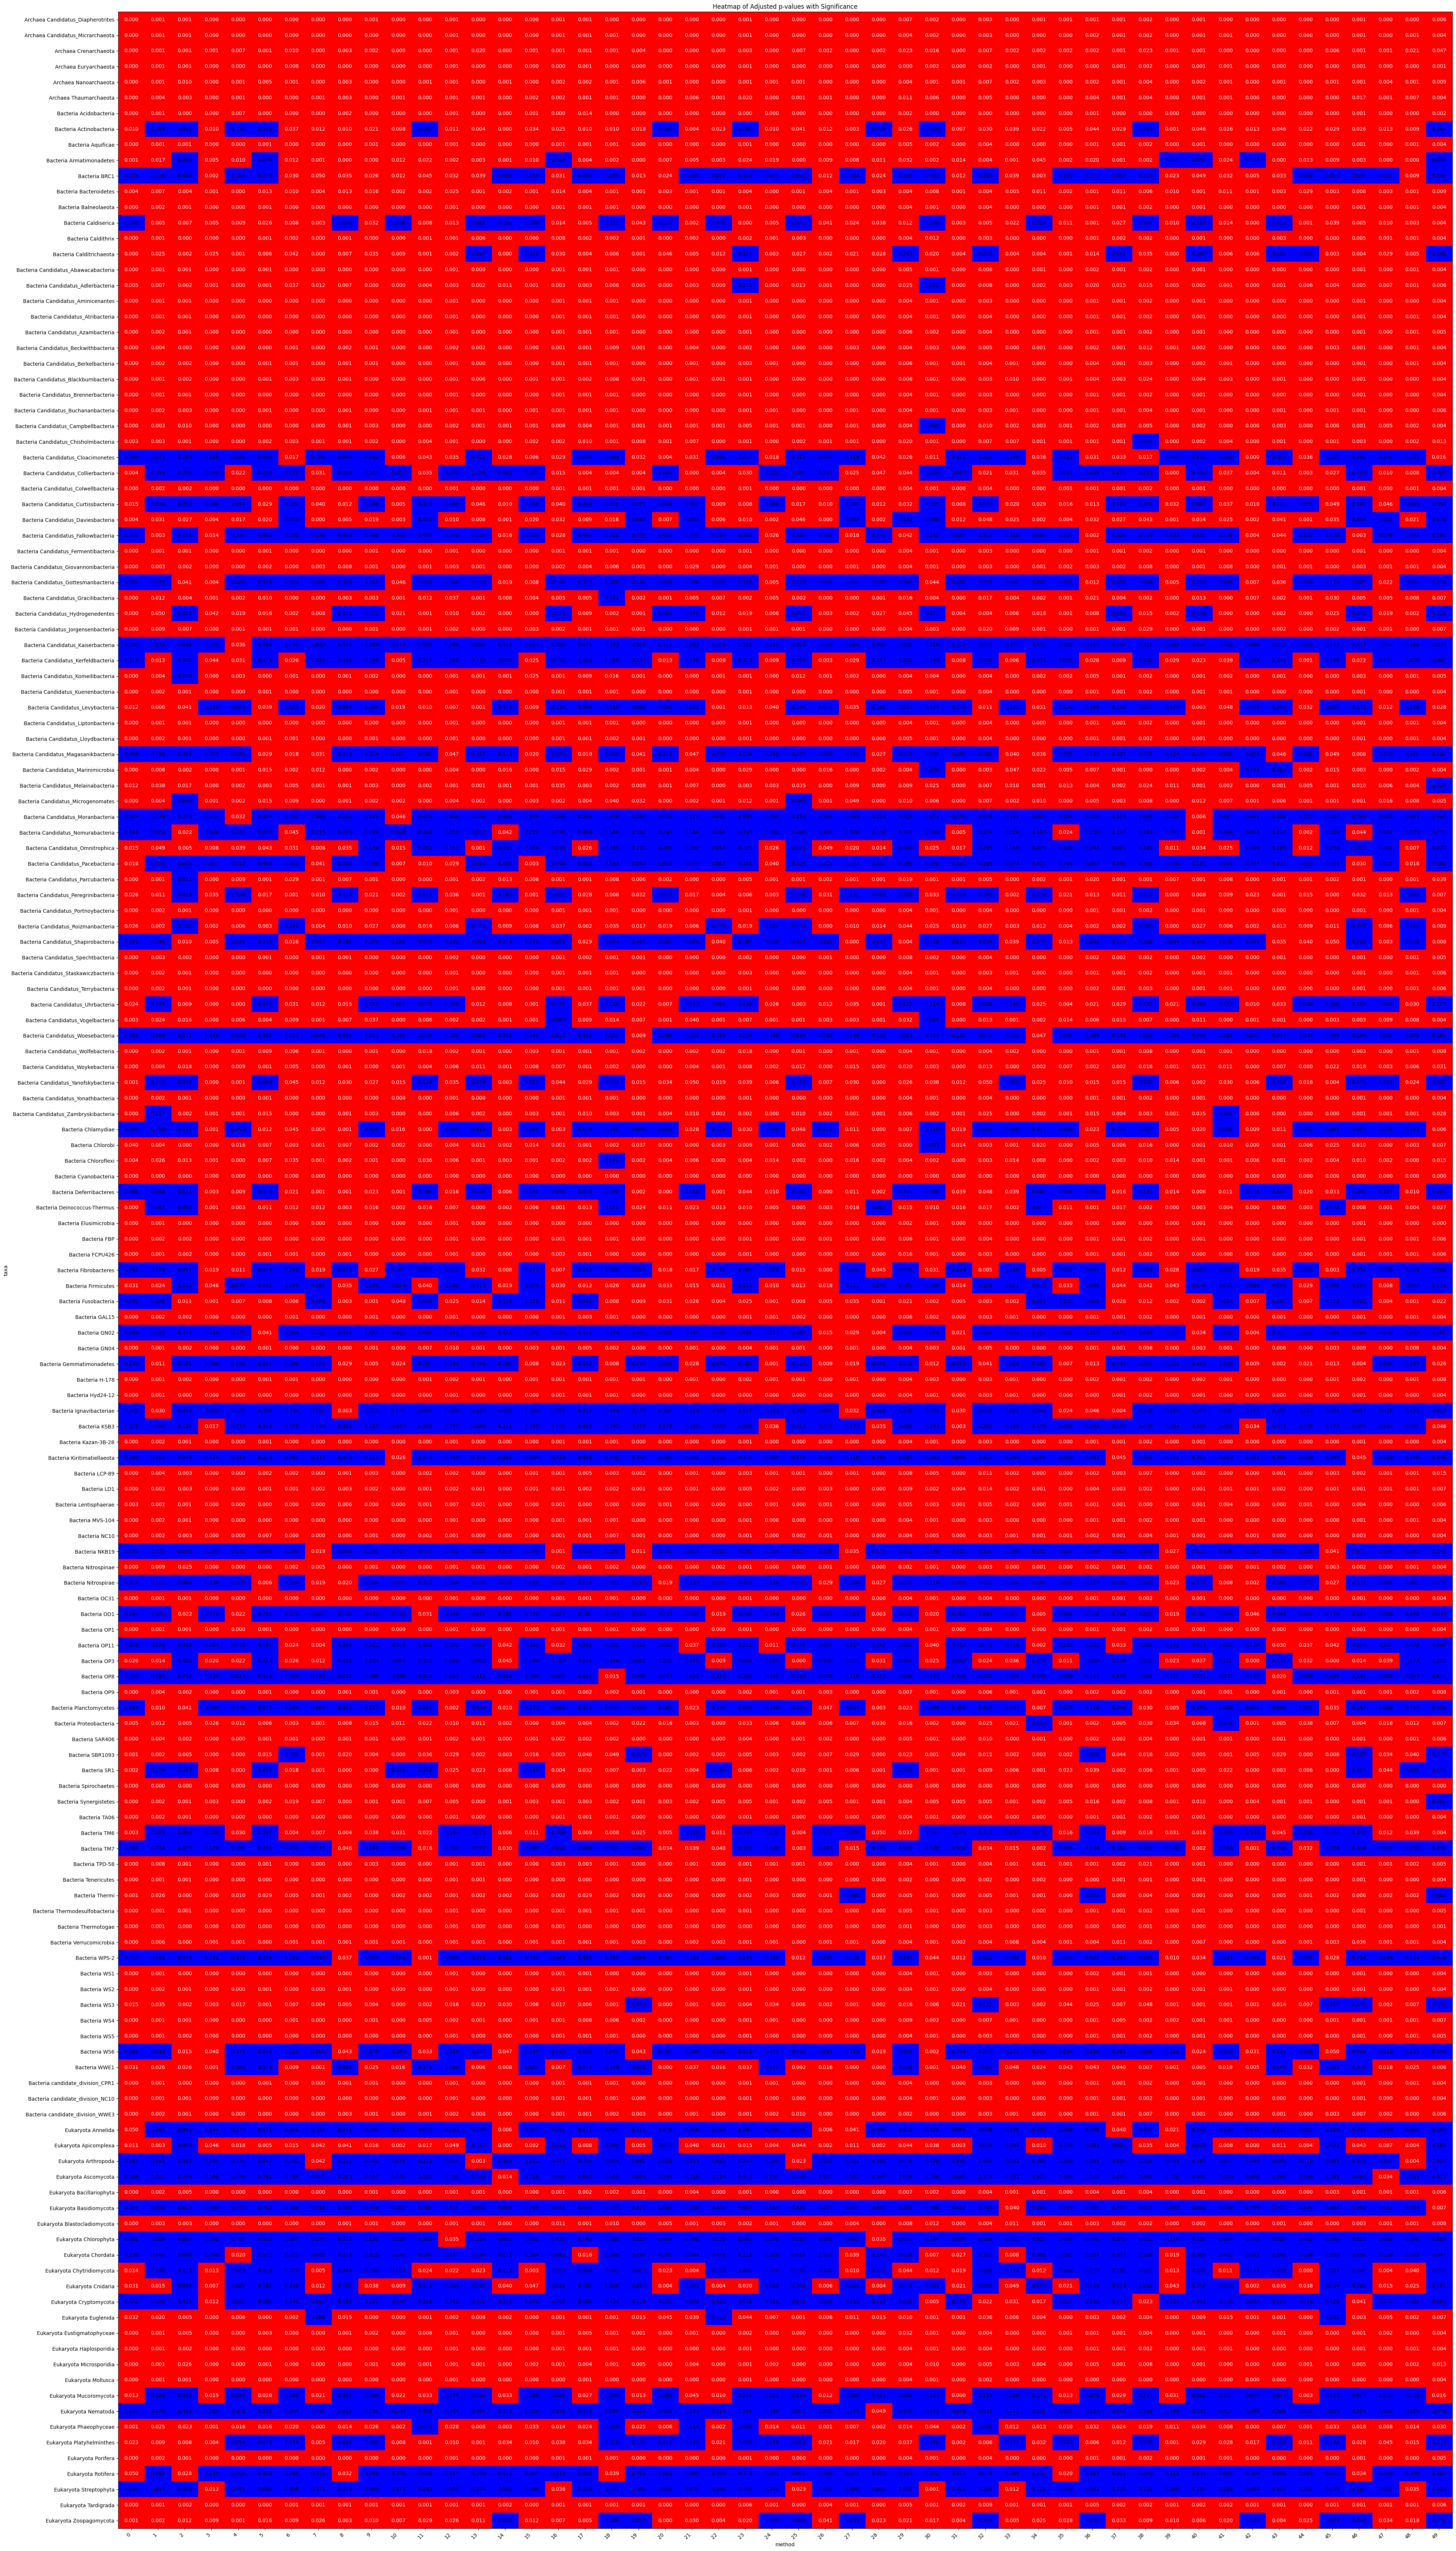

In [19]:
# Select DataFrame dataset and prior
dataset = "DTU-GE"
prior = "std_kl"
df = new_df[(new_df["dataset"] == dataset) & (new_df["prior"]==prior)]

# Pivot the DataFrame
pvals = df.pivot(index='taxa', columns='method', values='p_adj')
sig = df.pivot(index='taxa', columns='method', values='significant').astype(int)  # True->1, False->0

# Create a two-color colormap: blue for 0, red for 1
cmap = ListedColormap(['blue', 'red'])

# Plot
fig, ax = plt.subplots(figsize=(40, 70))
im = ax.imshow(sig, cmap=cmap, aspect='auto')

# Set ticks
ax.set_xticks(range(len(pvals.columns)))
ax.set_xticklabels(pvals.columns, rotation=45, ha='right')
ax.set_yticks(range(len(pvals.index)))
ax.set_yticklabels(pvals.index)

# Annotate with p_adj values
for i in range(sig.shape[0]):
    for j in range(sig.shape[1]):
        text = f"{pvals.iloc[i, j]:.3f}"
        ax.text(j, i, text, ha='center', va='center', color='white' if sig.iloc[i, j] else 'black')

ax.set_xlabel('method')
ax.set_ylabel('taxa')
ax.set_title('Heatmap of Adjusted p-values with Significance')
plt.grid(False)
plt.tight_layout()
plt.show()

pvals.to_excel(f"robustness_{dataset}_abaco_{prior}.xlsx", index=True)

## 2. Simulated data (balanced)

The following simulated data correction are going to be performed:
- Batch correction on data without batch effect (with significant different biological groups)
- Batch correction on data without batch effect (without significant different biological groups)
- Correction on data with batch effect (with significant different biological groups)
- Correction on data with batch effect (without significant different biological groups)

#### Creating simulated datasets

In [2]:
# Define random seed
np.random.seed(42)

n_samples = 100
n_features = 200
p_diff = 0.75
b_diff = 0.95

n_diff = int(n_features * p_diff)
b_diff = int(n_features * b_diff)

batches = ["Batch 1", "Batch 2"]
bios = ["A", "B"]

# Start several simulation data
sims = 50
sim_data_no_bt = []
sim_data_no_b = []
sim_data_no_t = []
sim_data_bt = []

for i in range(sims):

    # Build metadata
    metadata = pd.DataFrame({
        "SampleID": [f"S{i+1}" for i in range(n_samples)],
        "Condition": np.random.choice(bios, size=n_samples, replace=True),
        "Batch": np.random.choice(batches, size=n_samples, replace=True)
    })

    # Simulation settings per feature
    r = np.random.uniform(1.0, 3.0, size=n_features) # Dispersion
    p_zero = np.random.uniform(0.0, 0.1, size=n_features) # Probability of zero count

    # Baseline log-abundance and true effects
    baseline_log = np.random.normal(loc=2, scale=1, size=n_features)

    # Biological effect
    effect_sizes = np.zeros(n_features)
    effect_idx = np.random.choice(n_features, n_diff, replace = False)
    effect_sizes[effect_idx] = np.random.normal(loc=2.0, scale = 4.0, size=n_diff)

    # Batch effect
    batch_sizes = np.zeros(n_features)
    batch_idx = np.random.choice(n_features, b_diff, replace = False)
    batch_sizes[batch_idx] = np.random.normal(loc=5.0, scale = 2.0, size=b_diff)

    # Simulating counts without biological effect
    counts = np.zeros((len(metadata), n_features), dtype=int)
    counts_batch = np.zeros((len(metadata), n_features), dtype=int)
    for i, row in metadata.iterrows():
        mu = baseline_log
        mu_batch = mu + (batch_sizes if row["Batch"]==batches[1] else 0) # Batch shift on Batch 2
        p = r / (r + np.exp(mu))
        p_batch = r / (r + np.exp(mu_batch))
        is_zero = np.random.binomial(1, p_zero)
        counts_i = nbinom(r, p).rvs()
        counts[i, :] = np.where(is_zero==1, 0, counts_i)
        counts_i_batch = nbinom(r, p_batch).rvs()
        counts_batch[i, :] = np.where(is_zero==1, 0, counts_i_batch)
    
    # Case 1: No batch, no bio
    count_matrix_no_bt = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_bt = pd.concat([metadata, count_matrix_no_bt], axis = 1)
    # Case 2: Batch, no bio
    count_matrix_no_t = pd.DataFrame(counts_batch, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_t = pd.concat([metadata, count_matrix_no_t], axis = 1)

    sim_data_no_bt.append(count_matrix_no_bt)
    sim_data_no_t.append(count_matrix_no_t)
    
    # Simulating counts with biological effect
    counts = np.zeros((len(metadata), n_features), dtype=int)
    counts_batch = np.zeros((len(metadata), n_features), dtype=int)
    for i, row in metadata.iterrows():
        mu = baseline_log + (effect_sizes if row["Condition"]==bios[1] else 0) # Biological shift on group B
        mu_batch = mu + (batch_sizes if row["Batch"]==batches[1] else 0) # Batch shift on Batch 2
        p = r / (r + np.exp(mu))
        p_batch = r / (r + np.exp(mu_batch))
        is_zero = np.random.binomial(1, p_zero)
        counts_i = nbinom(r, p).rvs()
        counts[i, :] = np.where(is_zero==1, 0, counts_i)
        counts_i_batch = nbinom(r, p_batch).rvs()
        counts_batch[i, :] = np.where(is_zero==1, 0, counts_i_batch)
    
    # Case 3: No batch, bio
    count_matrix_no_b = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_no_b = pd.concat([metadata, count_matrix_no_b], axis = 1)
    # Case 4: Batch, bio
    count_matrix_bt = pd.DataFrame(counts_batch, columns = [f"OTU{j+1}" for j in range(n_features)])
    count_matrix_bt = pd.concat([metadata, count_matrix_bt], axis = 1)

    sim_data_no_b.append(count_matrix_no_b)
    sim_data_bt.append(count_matrix_bt)

# Plot boxplot for explained variance
# r2_results = []

# for df in sim_data:
#     # Separate metadata and features
#     df = DataTransform(df, factors = ["SampleID", "Batch", "Condition"], count=True)
#     metadata = df[['SampleID','Condition','Batch']].set_index('SampleID')
#     feature_data = df.drop(columns=['SampleID','Condition','Batch'])

#     # Compute Aitchison distance
#     dist_array = pdist(feature_data.values, metric='euclidean')
#     dm = DistanceMatrix(squareform(dist_array), ids=metadata.index.tolist())

#     # PERMANOVA for Condition
#     res_c = permanova(dm, grouping=metadata['Condition'], permutations=999)
#     # PERMANOVA for Batch
#     res_b = permanova(dm, grouping=metadata['Batch'], permutations=999)

#     # Extract parameters for R2 calculation
#     N = int(res_c['sample size'])
#     g_c = int(res_c['number of groups'])
#     g_b = int(res_b['number of groups'])
#     F_c = float(res_c['test statistic'])
#     F_b = float(res_b['test statistic'])

#     dfB_c, dfW_c = g_c - 1, N - g_c
#     dfB_b, dfW_b = g_b - 1, N - g_b

#     # Compute R2
#     r2_c = (F_c * dfB_c) / (F_c * dfB_c + dfW_c)
#     r2_b = (F_b * dfB_b) / (F_b * dfB_b + dfW_b)

#     r2_results.append({'Condition_R2': r2_c, 'Batch_R2': r2_b})

# # Compile all runs
# df_r2_all = pd.DataFrame(r2_results)

# # Boxplot of R2
# plt.figure()
# df_r2_all.boxplot(showfliers = False)
# plt.ylabel('PERMANOVA R²')
# plt.title('Distribution of Explained Variance Across Simulations')
# plt.tight_layout()
# plt.show()

In [16]:
data=sim_data_bt[2]
plotPCoA(data, sample_label="SampleID", batch_label="Batch", experiment_label="Condition")

#### Batch correction using other methods

In [ ]:
clr_combat = correctCombat(clr_count_matrix_gt, sample_label="SampleID", batch_label="Batch", experiment_label="Condition")
clr_limma = correctLimma_rBE(clr_count_matrix_gt, sample_label="SampleID", batch_label="Batch", covariates_labels=["Condition"])
clr_bmc = correctBMC(clr_count_matrix_gt, sample_label="SampleID", batch_label="Batch", exp_label="Condition")

plt.figure()
df_r2.boxplot(showfliers=False)
plt.ylabel("R2")
plt.title("Explained variance per feature")
plt.tight_layout()
plt.show()

Found 2 batches.
Adjusting for 1 covariate(s) or covariate level(s).
Standardizing Data across genes.
Fitting L/S model and finding priors.
Finding parametric adjustments.
Adjusting the Data


In [99]:
# Correlation matrix Σ via precision L
L = np.random.uniform(-1.5, 1.5, size=(n_features, n_features))
np.fill_diagonal(L, np.random.uniform(1.5, 2.5, size=n_features))
mask = np.random.rand(n_features, n_features) < 0.7
L[mask] = 0
R_prec = L @ L.T
D = np.sqrt(np.diag(1 / np.diag(R_prec)))
Sigma = D @ R_prec @ D

# Sample multivariate normal
X_norm = multivariate_normal.rvs(mean=np.zeros(n_features), cov=Sigma, size=n_samples)

# Design matrices
X_trt = pd.get_dummies(metadata['Condition'], drop_first=True).values
X_bat = pd.get_dummies(metadata['Batch'], drop_first=True).values
# Coefficients
mu_trt = 3.0
mu_bat = 0.0

sigma_trt = 1.0
sigma_bat = 1.0

delta = 1.0

beta_trt = np.random.normal(loc=mu_trt, scale=sigma_trt, size=(n_features, X_trt.shape[1]))
beta_bat = np.random.normal(loc=mu_bat, scale=sigma_bat, size=(n_features, X_bat.shape[1]))
# Random noise
eps = np.random.normal(0, delta, size=(n_samples, n_features))

Theta = np.exp(X_trt @ beta_trt.T + X_bat @ beta_bat.T + eps)

# Negative binomial CDF values
r = 20
P = r / (r + Theta)
# For each entry, map normal quantile to NB quantile
from scipy.stats import norm
U = norm.cdf(X_norm)
counts_mvnb = nbinom(r, P).ppf(U)

df_mvnb = pd.DataFrame(counts_mvnb, columns=[f'OTU{i+1}' for i in range(n_features)])
df_mvnb = pd.concat([metadata.reset_index(drop=True), df_mvnb], axis=1)

### Case 2: Data without significant biological different groups (no batch effect)

In [12]:
# Define random seed
np.random.seed(42)

n_samples = 100
n_features = 1000
p_diff = 0

n_diff = int(n_features * p_diff)

batches = ["Batch 1", "Batch 2"]
bios = ["A", "B"]

# Build metadata
metadata = pd.DataFrame({
    "SampleID": [f"S{i+1}" for i in range(n_samples)],
    "Condition": np.random.choice(bios, size=n_samples, replace=True),
    "Batch": np.random.choice(batches, size=n_samples, replace=True)
})

# Simulation settings per feature
theta = np.random.uniform(0.5, 2.0, size=n_features)
p_zero = np.random.uniform(0.1, 0.4, size=n_features)

# Baseline log-abundance and true effects
baseline_log = np.random.normal(loc=2, scale=1, size=n_features)
effect_sizes = np.zeros(n_features)
effect_idx = np.random.choice(n_features, n_diff, replace = False)
effect_sizes[effect_idx] = np.random.normal(loc=1.0, scale = 0.5, size=n_diff)

# Simulating counts (ground-truth)
counts = np.zeros((len(metadata), n_features), dtype=int)
for i, row in metadata.iterrows():
    mu = baseline_log + (effect_sizes if row["Condition"]==bios[1] else 0)
    p = theta / (theta + np.exp(mu))
    r = theta
    is_zero = np.random.binomial(1, p_zero)
    counts_i = nbinom(r, p).rvs()
    counts[i, :] = np.where(is_zero==1, 0, counts_i)

count_matrix_gt = pd.DataFrame(counts, columns = [f"OTU{j+1}" for j in range(n_features)])
count_matrix_gt = pd.concat([metadata, count_matrix_gt], axis = 1)

plotPCoA(data = count_matrix_gt, method = "aitchison", sample_label="SampleID", batch_label="Condition", experiment_label="Batch")

In [13]:
metadata.groupby(["Batch", "Condition"]).size()

Batch    Condition
Batch 1  A            25
         B            31
Batch 2  A            19
         B            25
dtype: int64

## Simulated data (unbalanced)